<a href="https://colab.research.google.com/github/connorrupnow/CHEM507_machinelearning/blob/main/MeltingPoints_KernalRidgeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melting Points KRR

*General Melting Point Prediction Based on a Diverse Compound Data Set and Artificial Neural Networks* (2005)

Data: https://pubs-acs-org.ezproxy.library.ubc.ca/doi/10.1021/ci0500132

- 4173 structures  extracted from MDPI database. 
- Melting points ranging from 14 °C and 392.5 °C.
- Some structures excluded from dataset:
  - Those with melting point ranges of larger than 5 °C
  - Those containing heavy metals (Sn, Se) 
  - Those sublimating or decomposing.

The paper describes a neural network to predict melting points. They acheived a mean absolute error (MAE) of around 38.2 °C for the test set predictions.

Target error I want to acheive: < 38.2 °C


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
def validation_plot(true_values, predicted_values):
  MAE = np.mean(abs(true_values - predicted_values))
  r2 = r2_score(true_values,predicted_values)

  fig, ax = plt.subplots()

  x_min = min(true_values)
  x_max = max(true_values)
  x = np.linspace(x_min,x_max,100)
  y = x

  ax.scatter(true_values,predicted_values)
  ax.set_xlabel('True')
  ax.set_ylabel("Predicted")
  ax.plot(x,y,'r')
  title = ax.set_title('Melting Point Predictions with MAE = %.3f and r2 = %.3f' % (MAE, r2))

We're going to look at 4 different models today and compare the MAE from the KRR models to the MAE found in the paper

## Analyze the data

import the data from the text file and analyze it

In [ ]:
filename = '/content/drive/MyDrive/CHEM507B/connors_applications/Melting Points (Karthikeyan)/4137_185_92_DataSetMTPSMIDescr.txt'
df = pd.read_table(filename)

In [ ]:
df = df.rename(columns={"$Field_1": "smiles", "$Field_2": "melting_point"})
df.head()

,Case,smiles,melting_point,diameter,petitjean,petitjeanSC,radius,VDistEq,VDistMa,weinerPath,weinerPol,a_aro,a_count,a_IC,a_ICM,a_nH,b_1rotN,b_1rotR,b_ar,b_count,b_double,b_rotN,b_rotR,b_single,b_triple,chi0v,chi0v_C,chi1v,chi1v_C,reactive,Weight,a_heavy,a_nBr,a_nC,a_nCl,a_nF,a_nI,a_nN,a_nO,a_nP,...,E_vdw,MNDO_dipole,MNDO_E,MNDO_Eele,MNDO_HF,MNDO_HOMO,MNDO_IP,MNDO_LUMO,dipole,pmi,rgyr,PM3_dipole,PM3_E,PM3_Eele,PM3_HF,PM3_HOMO,PM3_IP,PM3_LUMO,ASA,ASA+,ASA-,ASA_H,ASA_P,CASA+,CASA-,DASA,DCASA,FASA+,FASA-,FASA_H,FASA_P,FCASA+,FCASA-,VSA,dens,glob,std_dim1,std_dim2,std_dim3,vol
0,0,O=C1Cc2ccccc21,14.0,5,0.400000,0.666667,3,2.037476,6.011166,82,9,6,15,19.093584,1.272906,6,0,0.000000,6,16,1,0,0.000000,9,0,4.924756,4.516508,2.988581,2.784457,0,118.13499,9,0,8,0,0,0,0,1,0,...,14.135015,2.889006,-61.930481,-261.95663,13.335940,-9.64952,9.64952,-0.44925,0.554857,465.92532,1.985953,2.722717,-57.766014,-255.49719,21.304430,-9.84124,9.84124,-0.44209,292.80704,173.26636,119.54068,254.99756,37.809479,95.469757,65.866913,53.725670,29.602844,0.591742,0.408258,0.870872,0.129128,0.326050,0.224950,138.13699,0.958985,0.031032,1.853123,1.382682,0.326444,123.18750
1,0,Clc1ccc(cc1)C1c2c(OC(N)=C1C#N)[nH][nH0]c2C(F)(F)F,20.5,9,0.444444,0.800000,5,2.954872,8.805204,1046,40,11,31,63.522228,2.049104,8,4,0.121212,11,33,1,4,0.121212,20,1,12.034564,7.386751,6.689030,3.937393,0,340.69199,23,0,14,1,3,0,4,1,0,...,29.329494,6.707296,-210.075070,-1280.27610,-73.319733,-9.66534,9.66534,-0.88665,0.331284,3913.71970,3.389330,6.320718,-189.062620,-1253.55020,-65.299553,-9.35172,9.35172,-0.76930,490.86124,209.61472,281.24655,461.88745,28.973785,415.875580,557.993100,71.631828,142.117540,0.427035,0.572965,0.940974,0.059026,0.847237,1.136764,296.30197,1.296254,0.258447,2.394159,1.966377,1.217135,262.82812
2,0,O=C(OC)C(=Cc1ccccc1)Cc1ccccc1,27.5,10,0.500000,1.000000,5,3.083532,8.211762,742,24,12,35,44.038036,1.258230,16,6,0.166667,12,36,2,7,0.194444,22,0,10.874456,10.057960,6.172321,5.355825,0,252.31299,19,0,17,0,0,0,0,2,0,...,36.819839,2.136326,-131.953460,-854.63446,-20.477301,-9.35412,9.35412,-0.16594,0.158381,2827.00930,3.347294,1.911006,-123.453570,-846.66418,-19.763069,-9.59608,9.59608,-0.14751,500.93936,319.46854,181.47081,477.54193,23.397421,409.558690,232.645580,137.997740,176.913100,0.637739,0.362261,0.953293,0.046707,0.817581,0.464419,296.54431,0.946322,0.162139,3.164745,1.552043,1.274330,266.62500
3,0,FC(F)(F)c1[nH0]cc2ccccc2c1,30.5,7,0.428571,0.750000,4,2.616827,7.313269,288,20,10,20,32.954617,1.647731,6,1,0.047619,11,21,0,1,0.047619,10,0,7.045209,5.464102,3.992128,2.943376,0,197.15900,14,0,10,0,3,0,1,0,0,...,26.287914,5.992572,-130.465060,-592.12701,-104.337790,-9.48870,9.48870,-1.26582,0.649922,1528.72890,2.784562,5.203625,-119.714450,-569.76172,-109.907960,-9.68175,9.68175,-1.24756,354.64340,146.73663,202.04015,338.79492,15.848473,148.203990,203.858510,55.303513,55.654507,0.413758,0.569699,0.955312,0.044688,0.417896,0.574827,187.43799,1.195242,0.018573,2.524826,1.446899,0.344087,164.95312
4,0,O=C(OC1Cc2ccccc21)C,31.0,7,0.428571,0.750000,4,2.609669,6.833154,203,13,6,22,29.668934,1.348588,10,3,0.130435,6,23,1,3,0.130435,16,0,6.910355,6.093858,4.021778,3.377827,1,162.18800,12,0,10,0,0,0,0,2,0,...,17.876390,1.665363,-89.477844,-445.91672,-40.239811,-9.37723,9.37723,0.10964,0.212406,1042.49880,2.535295,1.759848,-83.474678,-438.95264,-32.226189,-9.51367,9.51367,0.24090,371.57895,256.36450,115.21445,332.96268,38.616283,221.242570,99.314850,141.150070,121.927730,0.689933,0.310067,0.896075,0.103925,0.595412,0.267278,193.42802,0.978233,0.088156,2.550456,1.430062,0.757260,165.79688


In [ ]:
meltingpoint_data = df[df.Case==0].drop(columns=['Case','smiles']).dropna()
meltingpoint_data_column_names = meltingpoint_data.columns

This leaves us with 202 molecular descriptors to predict the melting point.

There's too many descriptors to fully analyze, so let's take a look at some common ones and see if there are any trends.

In [ ]:
description_data = meltingpoint_data[['melting_point','Weight','dens']]
description_data.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
melting_point,165.874794,64.624803,14.000000,392.500000
Weight,316.690816,103.180939,84.077995,815.620970
dens,1.083077,0.143109,0.794493,1.895606


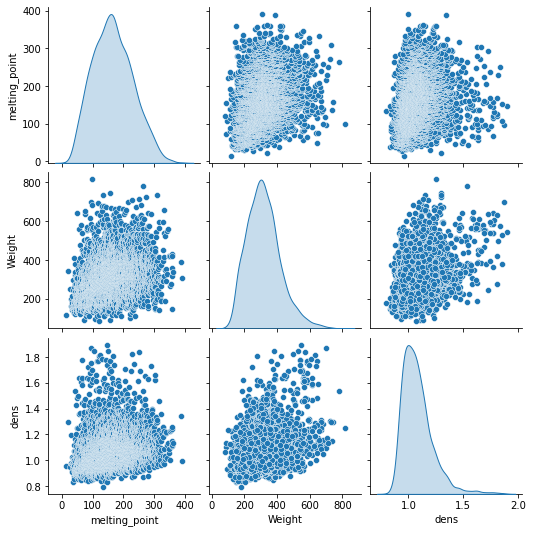

In [ ]:
import seaborn as sns
sns.pairplot(description_data,diag_kind='kde')

From this data you can tell that there appears to be no correlation between atomic weight, density, and melting point. We can also see that these 3 variables are gaussian and mostly well distributed, with density having a slight tail on the higher end.

## Prepare the Data

Randomly split the data into test and training data

In [ ]:
#Split into training and testing datasets
training_df = meltingpoint_data.sample(frac=0.8) #random_state is a seed value
testing_df = meltingpoint_data.drop(training_df.index)

print('Test Shape:', testing_df.shape,'. Train Shape:',training_df.shape)

#split the inputs (R1, R2, etc.) from the label (Energy)
training_labels_df = training_df['melting_point']
training_inputs_df = training_df.drop(['melting_point'],axis=1)
testing_labels_df = testing_df['melting_point']
testing_inputs_df = testing_df.drop(['melting_point'],axis=1)

#convert the data to numpy arrays and reshape them for the model
training_inputs = np.array(training_inputs_df).reshape(-1, 202)
training_labels = np.array(training_labels_df).reshape(-1,1)
testing_inputs = np.array(testing_inputs_df).reshape(-1,202)
testing_labels = np.array(testing_labels_df).reshape(-1,1)

Test Shape: (825, 203) . Train Shape: (3301, 203)


##  Basic KRR Model

For the basic KRR model I'll be using the radial basis function (RBF) kernel.

In [ ]:
kernel_ridge_model = KernelRidge(kernel='rbf',alpha=1) #kernel='rbf'

stime = time.time()
kernel_ridge_model.fit(training_inputs, training_labels)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

stime = time.time()
predictions = kernel_ridge_model.predict(testing_inputs)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

#print(predictions)

Time for KRR fitting: 1.125
Time for KRR prediction: 0.193


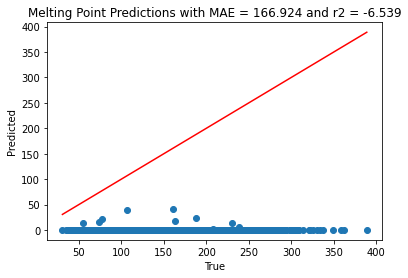

In [ ]:
initial_predictions = predictions
initial_true_values = testing_labels

validation_plot(initial_true_values,initial_predictions)

This model performed very poorly for reasons I don't quite understand. But we can try some more techniques to improve it.

## Normalize the data

Normalization processes the data to be on same scale. Although a model might converge without feature normalization, normalization makes training much more stable.

In [ ]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(training_inputs)
scaler_y = StandardScaler().fit(training_labels)

normalized_xtest = scaler_x.transform(testing_inputs)
normalized_ytest = scaler_y.transform(testing_labels)
normalized_xtrain = scaler_x.transform(training_inputs)
normalized_ytrain = scaler_y.transform(training_labels)

The mean is now zero and the standard deviation is 1. Let's run our KRR model again and see if it's any better.

Time for KRR fitting: 1.075
Time for KRR prediction: 0.175


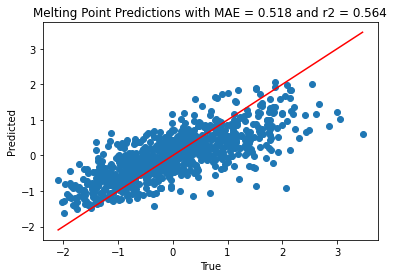

In [ ]:
kernel_ridge_model = KernelRidge(kernel='rbf',alpha=1) #kernel='rbf'

stime = time.time()
kernel_ridge_model.fit(normalized_xtrain, normalized_ytrain)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

stime = time.time()
predictions = kernel_ridge_model.predict(normalized_xtest)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

scaled_predictions = predictions
scaled_true_values = normalized_ytest

validation_plot(scaled_true_values,scaled_predictions)

This looks better! We're actually getting some predictions now. Let's finetune the hyperparameters.

## Parameter Tuning

There are a few parameters we can tune, depending on the kernel we choose.

In [ ]:
kernel_ridge_model.get_params(deep=True)

{'alpha': 1,
 'coef0': 1,
 'degree': 3,
 'gamma': None,
 'kernel': 'rbf',
 'kernel_params': None}

We will focus on two main parameters; alpha and kernel. 

**alpha**: is the L2 regularization coefficient.

**kernel**:  kernel function passed to the model.

===================================================================================================================

The description of the other parameters from the sklearn documentation are included below for reference.


**gamma** float, default=None

Gamma parameter for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels. Interpretation of the default value is left to the kernel; Ignored by other kernels.

**degree** float, default=3

Degree of the polynomial kernel. Ignored by other kernels.

**coef0** float, default=1

Zero coefficient for polynomial and sigmoid kernels. Ignored by other kernels.




I'll perform a grid search through a few valid kernels and values of alpha

In [ ]:
fitting_times = []
prediction_times = []
MAE_vals = []
model_kernel = []
model_alpha = []

true_values = normalized_ytest
alpha_vals =  [1e1, 1e0, 1e-1, 1e-2, 1e-3]
kernels = ["linear", "poly", "rbf", "sigmoid"]
print('kernel', 'alpha', 'fitting_time', 'prediction_time')
for kernel in kernels:
  for alpha in alpha_vals:
    
    #save some variables for later
    model_kernel.append(kernel)
    model_alpha.append(alpha)

    # compile model
    kernel_ridge_model = KernelRidge(kernel=kernel,alpha=alpha,degree=5) #kernel='rbf'

    # fit model
    stime = time.time()
    kernel_ridge_model.fit(normalized_xtrain, normalized_ytrain)
    fitting_time = time.time() - stime
    fitting_times.append(fitting_time)

    # make predictions
    stime = time.time()
    predictions = kernel_ridge_model.predict(normalized_xtest)
    prediction_time = time.time() - stime
    prediction_times.append(prediction_time)

    print(kernel, alpha, round(fitting_time,4), round(prediction_time,4))

    # evaluate model
    MAE_vals.append(np.mean(abs(true_values - predictions)))

kernel alpha fitting_time prediction_time
linear 10.0 0.7713 0.0511
linear 1.0 0.7257 0.0542
linear 0.1 0.7564 0.056
linear 0.01 0.7251 0.0555
linear 0.001 0.7637 0.0532
poly 10.0 1.5719 0.3116
poly 1.0 1.5671 0.3069
poly 0.1 1.56 0.2998
poly 0.01 1.5571 0.296
poly 0.001 1.5697 0.2967
rbf 10.0 1.0051 0.1578
rbf 1.0 0.9969 0.1546
rbf 0.1 1.0129 0.1663
rbf 0.01 1.0084 0.1549
rbf 0.001 0.9929 0.1692


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


sigmoid 10.0 12.4063 0.2193


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


sigmoid 1.0 12.2227 0.2286


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


sigmoid 0.1 12.2694 0.2123


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


sigmoid 0.01 12.3541 0.2089


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


sigmoid 0.001 12.2685 0.2335


The lowest MAE is for a model with rbf kernel and and alpha value of 0.1
Min MAE:  0.50837


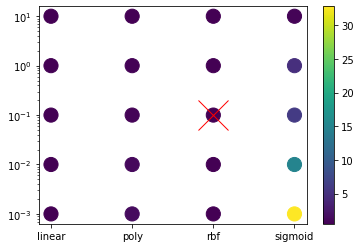

In [ ]:
plt.scatter(model_kernel,model_alpha,c=MAE_vals,s=200)
plt.colorbar()
ax = plt.gca()
ax.set_yscale('log')

ind_min = np.argmin(MAE_vals)
best_kernel = model_kernel[ind_min]
best_alpha = model_alpha[ind_min]

plt.plot(model_kernel[ind_min], model_alpha[ind_min], color="red", marker="x", ms=30)
print('The lowest MAE is for a model with', best_kernel,'kernel and and alpha value of', best_alpha)
print('Min MAE: ', round(np.min(MAE_vals),5))

Time for KRR fitting: 1.030
Time for KRR prediction: 0.167


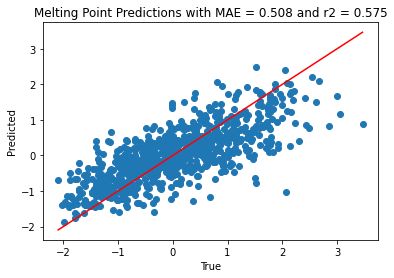

In [ ]:
# now run the code with the optimized parameters
kernel_ridge_model = KernelRidge(kernel=best_kernel,alpha=best_alpha) #kernel='rbf'

stime = time.time()
kernel_ridge_model.fit(normalized_xtrain, normalized_ytrain)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

stime = time.time()
predictions = kernel_ridge_model.predict(normalized_xtest)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

optimized_predictions = predictions
optimized_true_values = normalized_ytest

validation_plot(optimized_true_values,optimized_predictions)

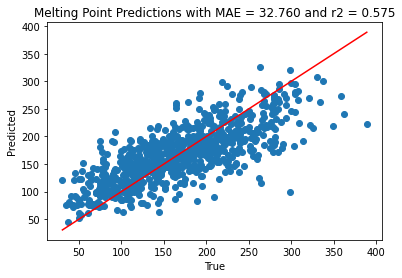

In [ ]:
unscaled_optimized_predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
unscaled_optimized_true_values = scaler_y.inverse_transform(normalized_ytest) #testing_labels 

validation_plot(unscaled_optimized_true_values,unscaled_optimized_predictions)

## DNN Prediction

Let's build a quick DNN just to see if it can predict any better

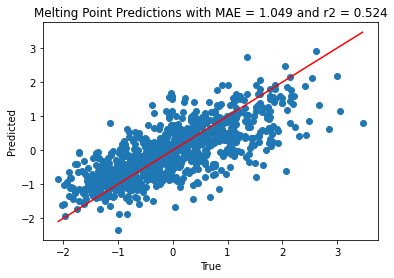

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Build your DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_dim=202),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)])

model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"))

results = model.fit(normalized_xtrain, normalized_ytrain, epochs=50,verbose=0)

predictions = model.predict(normalized_xtest)

DNN_predictions = predictions[:,0]
DNN_true_values = normalized_ytest

validation_plot(DNN_true_values,DNN_predictions)

## MAE Comparison

Let's compare the MAE of each of our models to the MAE found in the paper

In [ ]:
literature_MAE = 38.2
optimized_MAE = np.mean(abs(unscaled_optimized_true_values - unscaled_optimized_predictions))
unscaled_MAE = np.mean(abs(initial_true_values - initial_predictions))

#need to unscale DNN predictions to calculate MAE
DNN_model_predictions = scaler_y.inverse_transform(DNN_predictions.reshape(-1, 1))
DNN_model_true_values = scaler_y.inverse_transform(normalized_ytest) #testing_labels 
DNN_MAE = np.mean(abs(DNN_model_true_values - DNN_model_predictions))

#need to unscale scaled KRR predictions to calculate MAE
scaled_model_predictions = scaler_y.inverse_transform(scaled_predictions.reshape(-1, 1))
scaled_model_true_values = scaler_y.inverse_transform(normalized_ytest) #testing_labels 
scaled_MAE = np.mean(abs(scaled_model_true_values - scaled_model_predictions))

labels = ["from literature","initial model","scaled model","optimized model","DNN model"]
MAEs = np.array([literature_MAE,unscaled_MAE,scaled_MAE,optimized_MAE,DNN_MAE])

MAE_table = pd.DataFrame(MAEs, index=labels,columns=['MAE (°C)'])

MAE_perc_diff = (MAEs - literature_MAE)/literature_MAE*100
MAE_table['% difference'] = MAE_perc_diff

MAE_table.round(1)

,MAE (°C),% difference
from literature,38.2,0.0
initial model,166.9,337.0
scaled model,33.4,-12.6
optimized model,32.8,-14.2
DNN model,34.8,-8.8


I succesfully built a better prediction model than was made in literature 16 years ago! I attribute that to my success to advances in machine learning methods since 2005. This paper was written before sklearn and TensorFlow was invented.

Some notes:
- Not sure why the initial data set made a really poor model
- Sigmoid function during grid search fails for low (all) values of alpha
- Chemistry problems generally need 60 data points per des

Could improve model by:
- building a more extensive hyperparameter (gamma, coeff0, etc.) grid search
- using a Gaussian process to tune the hyperparameters
- Applying PCA to the data first
  - the paper applies PCA and uses the top 40 principal components


To Do:
- remove features via PCA
- remove cateogrical variables
- train by cross validation

## PCA to KRR

In [ ]:
from sklearn.decomposition import PCA

# create the PCA instance
pca = PCA(40) #using 40 principal components

pca_xscaler = pca.fit(normalized_xtrain)

xtest_reduced = pca_xscaler.transform(normalized_xtest)
xtrain_reduced = pca_xscaler.transform(normalized_xtrain)
# xtest_reduced = pca_xscaler.transform(testing_inputs)
# xtrain_reduced = pca_xscaler.transform(training_inputs)
print(xtrain_reduced.shape)
print(normalized_ytrain.shape)

(3301, 40)
(3301, 1)


Time for KRR fitting: 0.972
Time for KRR prediction: 0.143


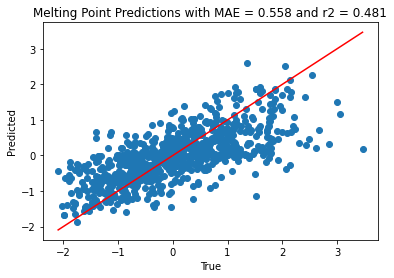

In [ ]:
# now run the code with the optimized parameters
kernel_ridge_model = KernelRidge(kernel=best_kernel,alpha=best_alpha) #kernel='rbf'

stime = time.time()
kernel_ridge_model.fit(xtrain_reduced, normalized_ytrain)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

stime = time.time()
predictions = kernel_ridge_model.predict(xtest_reduced)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

reduced_predictions = predictions
reduced_true_values = normalized_ytest

validation_plot(reduced_true_values,reduced_predictions)